In [1]:
import xarray as xr
import pymc as pymc
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import datetime
import arviz as az


from scipy.special import expit

from werp_projecting_sfis.file_io import sfi_file_to_pandas, inpredictor_function


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [29]:
# filename = r"C:/Users/rob635/OneDrive - CSIRO/WERP/SFI_Projection/Data/_MURR_B0H000__eFA_annual_stats_10discount.txt"
# outdf0 = sfi_file_to_pandas(filename)
# outdf0['ewater'] = 0.0

filename1 = r"/Users/26wanga/Documents/ORAC/CSIRO/_MURR_P0H000__eFA_annual_stats_10discount.txt"
outdf1 = sfi_file_to_pandas(filename1)
outdf1['ewater'] = 2750.0

#outdf = pd.concat([outdf0,outdf1], axis=0)
outdf = outdf1.copy(deep=True)

NameError: name 'outdf0' is not defined

In [31]:
print (outdf1['ewater'])

1896-06-30    2750.0
1897-06-30    2750.0
1898-06-30    2750.0
1899-06-30    2750.0
1900-06-30    2750.0
               ...  
2005-06-30    2750.0
2006-06-30    2750.0
2007-06-30    2750.0
2008-06-30    2750.0
2009-06-30    2750.0
Freq: YE-JUN, Name: ewater, Length: 114, dtype: float64


In [2]:

x = inpredictor_function("/Users/26wanga/Documents/ORAC/CSIRO/MURR_P0H.csv")
x['ewater'] = 2750.0

# inflowfile = "C:/Users/rob635/OneDrive - CSIRO/WERP/SFI_Projection/Data/InflowData_from modelled outputs_B0H/MURR.csv"

# inpredictor = pd.read_csv(inflowfile)
# inpredictor['date'] = pd.to_datetime(inpredictor['date'])
# inpredictor.set_index('date', inplace=True)
# inpredictor
# annualpredictor1 = inpredictor.resample("YE-JUN").sum()
# annualpredictor1['ewater'] =  0.0

# annualpredictor = pd.concat([annualpredictor1, annualpredictor0], axis = 0)

annualpredictor = x.copy(deep=True)


In [325]:
laggedinflow_predictor = annualpredictor.copy(deep=True)
laggedtimeindex = laggedinflow_predictor.index
laggedtimeindexstring = [ str(laggedtime.year-1) + "-" + str(laggedtime.month) + "-" + str(laggedtime.day) for laggedtime in laggedtimeindex]
laggedinflow_predictor.index = pd.to_datetime(laggedtimeindexstring)
laggedinflow_predictor.columns = [col +"_lagged" for col in laggedinflow_predictor.columns]


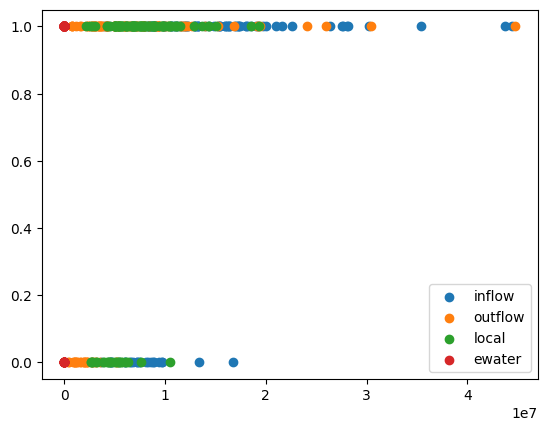

In [326]:
for col in annualpredictor.columns:
    plt.scatter(annualpredictor[col], outdf['BMF_R1'], label = col)

plt.legend()

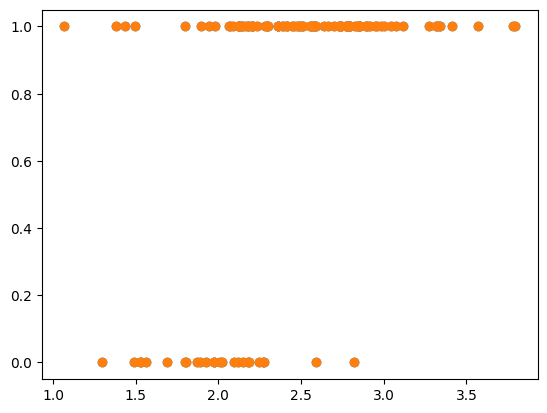

In [327]:
data = pd.concat([annualpredictor['inflow'],outdf['BMF_R1']],axis=1, join='inner')
data['inflow'] = np.log(data['inflow']/1000000)

data = data.reset_index()[data.columns[-2:]]

plt.scatter(x=data['inflow'], y= data['BMF_R1'])

data = data.sort_values(by = 'inflow')

plt.scatter(x=data['inflow'], y= data['BMF_R1'])

In [21]:
data = pd.concat([annualpredictor['inflow'],outdf['BMF_R3']],axis=1, join='inner')
data['inflow'] = (data['inflow']/1000000)

data = data.reset_index()[data.columns[-2:]]

plt.scatter(x=data['inflow'], y= data['BMF_R3'])

data = data.sort_values(by = 'inflow')
n = 1 #data.shape[0]

plt.scatter(data['inflow'], data['BMF_R3'], label = col)

with pymc.Model() as binomial_regression_model:
    x = pymc.Data("x", (data['inflow']))
    # priors
    beta0 = pymc.Normal("beta0", mu=0, sigma=100)
    beta1 = pymc.Normal("beta1", mu=0, sigma=100)
    # linear model
    mu = beta0 + beta1 * x
    p = pymc.Deterministic("p", pymc.math.invlogit(mu))
    print(mu, p)
    # likelihood
    pymc.Binomial("y", n=n, p=p, observed=data['BMF_R3'])

NameError: name 'outdf' is not defined

In [22]:
binomial_regression_model1 = pymc.Model()

In [330]:
pymc.sample(2000,tune = 4000, chains = 4, model=binomial_regression_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1]


Output()

Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 5 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [331]:
with binomial_regression_model:
    idata = pymc.sample(2000, tune=4000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1]


Output()

Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 4 seconds.


array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>]], dtype=object)

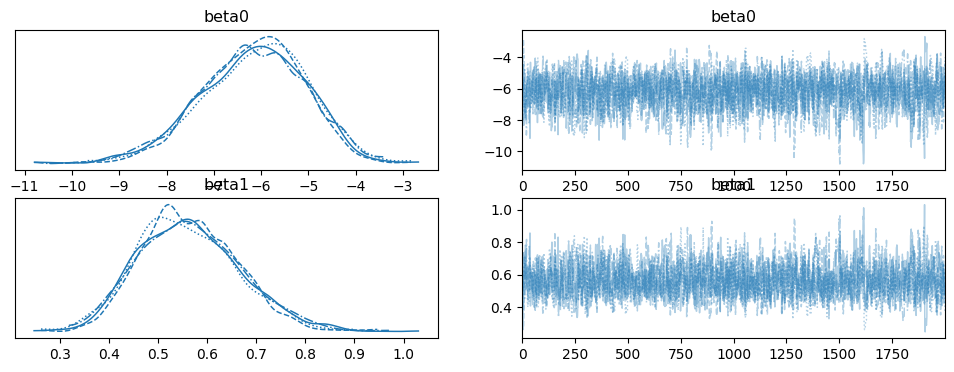

In [332]:
az.plot_trace(idata, var_names=["beta0", "beta1"])

In [333]:
p_true = (data["BMF_R3"])

[[<matplotlib.axis.YTick at 0x1760981c0>,

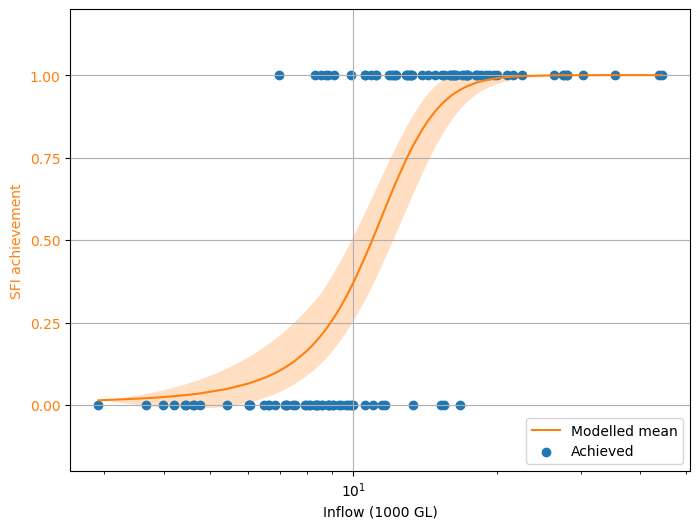

In [334]:
fig, ax = plt.subplots(1, 1, figsize=(8,6)) #, gridspec_kw={"width_ratios": [2, 1]})

# Data space plot ========================================================
az.plot_hdi(
    data["inflow"],
    idata.posterior.p,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    ax=ax,
    color="C1",
)
# posterior mean
post_mean = idata.posterior.p.mean(("chain", "draw"))
ax.plot(data["inflow"], post_mean, label="Modelled mean", color="C1")
# plot truth
ax.scatter(data["inflow"], p_true,  label="Achieved")
# formatting
ax.set(xlabel="Inflow (1000 GL)")
ax.set_ylabel("SFI achievement", color="C1")
ax.tick_params(axis="y", labelcolor="C1")
ax.legend(loc="lower right")
ax.set_xscale('log')
# instantiate a second axes that shares the same x-axis
#freq = ax.twinx()
# freq.set_ylabel("number of successes")
# freq.scatter(data["inflow"], data["BMF_R3"], color="k", label="data")
# get y-axes to line up
y_buffer = 0.2
#freq.set(ylim=[-y_buffer, n + y_buffer])
ax.set(ylim=[-(y_buffer / n), 1 + (y_buffer / n)])
ax.grid()
# freq.grid(None)
# # set both y-axis to have 5 ticks
ax.set(yticks=np.linspace(0, n, 5) / n)
# freq.set(yticks=np.linspace(0, n, 5))

# # Parameter space plot ===================================================
# az.plot_kde(
#     az.extract(idata, var_names="beta0"),
#     az.extract(idata, var_names="beta1"),
#     contourf_kwargs={"cmap": "Blues"},
#     ax=ax[1],
# )
# #ax[1].plot(beta0_true, beta1_true, "C2o", label="true")
# ax[1].set(xlabel=r"$\beta_0$", ylabel=r"$\beta_1$", title="Parameter space")
# ax[1].legend(facecolor="white", frameon=True);

In [335]:
predictdata1 = data.copy(deep=True)
predictdata2 = data.copy(deep = True)
predictdata1 = predictdata1[0:100]
predictdata2 = predictdata2[0:100]
predictdata1['inflow'] = np.exp(np.log(data['inflow'].min() )+np.array([float(a)/float(100.) for a in range(100)] )* (np.log(data['inflow'].max())-np.log(data['inflow'].min())))
predictdata2['inflow'] = np.exp(np.log(data['inflow'].min() )+np.array([float(a)/float(100.) for a in range(100)] )* (np.log(data['inflow'].max())-np.log(data['inflow'].min())))

In [336]:
predictdata1.drop(columns=['BMF_R3'],inplace=True)

In [337]:
with binomial_regression_model:
    pymc.set_data({'x':predictdata1['inflow'] })
    idata1 = pymc.sample_posterior_predictive(idata,  var_names="p")

    pymc.set_data({'x':predictdata2['inflow']})
    idata2 = pymc.sample_posterior_predictive(idata, var_names="p")

Sampling: []


Output()

Sampling: []


Output()

In [338]:
with binomial_regression_model:
    pymc.set_data({'x':predictdata2['inflow'] })
    idata = pymc.sample_posterior_predictive(idata,  var_names=["p"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True,)

Sampling: []


Output()

In [339]:
outquants1 = idata1.posterior_predictive.p.quantile(q= [0.025,0.25,0.5,0.75,0.975], dim = ("chain",'draw') )
outquants2 = idata2.posterior_predictive.p.quantile(q= [0.025,0.25,0.5,0.75,0.975], dim = ("chain",'draw') )

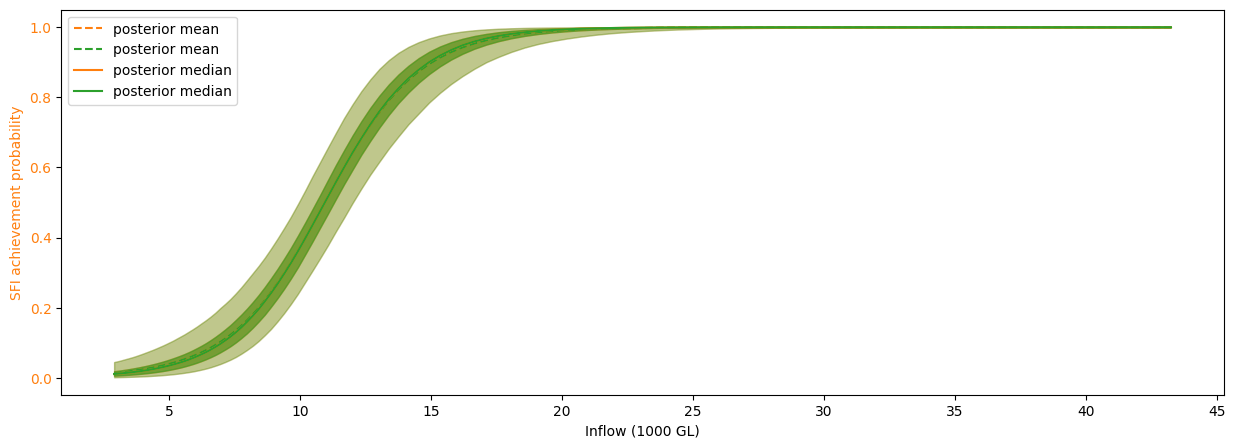

In [340]:
fig, ax = plt.subplots(1, 1, figsize=(15,5)) #, gridspec_kw={"width_ratios": [2, 1]})


ax.fill_between(x = (predictdata1['inflow']), y1 = outquants1.loc[{'quantile':0.025}].data ,y2 = outquants1.loc[{'quantile':0.975}].data, color = "C1", alpha = 0.3)
ax.fill_between(x = (predictdata2['inflow']), y1 = outquants2.loc[{'quantile':0.025}].data ,y2 = outquants2.loc[{'quantile':0.975}].data, color = "C2", alpha = 0.3)
ax.fill_between(x = (predictdata1['inflow']), y1 = outquants1.loc[{'quantile':0.25}].data ,y2 = outquants1.loc[{'quantile':0.75}].data, color = "C1", alpha = 0.6)
ax.fill_between(x = (predictdata2['inflow']), y1 = outquants2.loc[{'quantile':0.25}].data ,y2 = outquants2.loc[{'quantile':0.75}].data, color = "C2", alpha = 0.6)

# posterior mean
post_mean1 = idata1.posterior_predictive.p.mean(("chain", "draw"))
post_mean2 = idata2.posterior_predictive.p.mean(("chain", "draw"))
ax.plot(predictdata1["inflow"], post_mean1, label="posterior mean", color="C1", linestyle = "--")
ax.plot(predictdata2["inflow"], post_mean2, label="posterior mean", color="C2", linestyle = "--")

ax.plot(predictdata1["inflow"], outquants1.loc[{'quantile':0.5}].data, label="posterior median", color="C1")
ax.plot(predictdata2["inflow"], outquants2.loc[{'quantile':0.5}].data, label="posterior median", color="C2")

# plot truth
#ax.scatter(data["inflow"], p_true,  label="true", color="C2")
# formatting
ax.set(xlabel="Inflow (1000 GL)")
#ax.set_xscale('log')
ax.set_ylabel("SFI achievement probability", color="C1")
ax.tick_params(axis="y", labelcolor="C1")
ax.legend()

In [341]:
predictdata1 = data.sample(n=10, axis = 0)
predictdata2 = data.sample(n=10, axis = 0)

with binomial_regression_model:
    pymc.set_data({'x':predictdata1['inflow'] })
    idata1 = pymc.sample_posterior_predictive(idata,  var_names="p")

    pymc.set_data({'x':predictdata2['inflow']})
    idata2 = pymc.sample_posterior_predictive(idata, var_names="p")

outquants1 = idata1.posterior_predictive.p.quantile(q= [0.025,0.25,0.5,0.75,0.975], dim = ("chain",'draw') )
outquants2 = idata2.posterior_predictive.p.quantile(q= [0.025,0.25,0.5,0.75,0.975], dim = ("chain",'draw') )

Sampling: []


Output()

Sampling: []


Output()

Text(0.5, 0, 'Year')

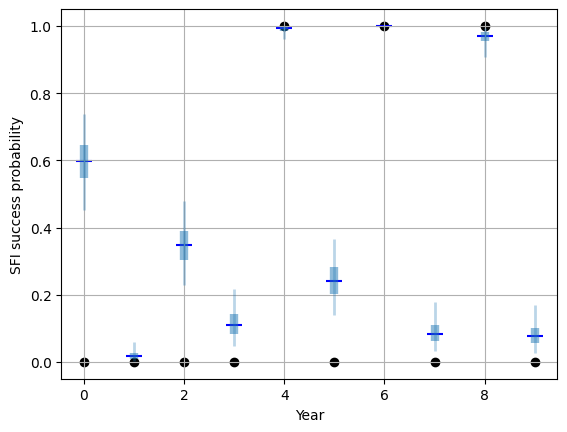

In [342]:
pltx = [a for a in range(predictdata1.shape[0])]
plt.scatter(x=pltx, y = predictdata1['BMF_R3'].values , c='black')
plt.vlines(x=pltx, ymin = outquants1.loc[{'quantile':0.025}].data ,ymax = outquants1.loc[{'quantile':0.975}].data , linewidths = 2, alpha = 0.3)
plt.vlines(x=pltx, ymin = outquants1.loc[{'quantile':0.25}].data ,ymax = outquants1.loc[{'quantile':0.75}].data , linewidths = 6, alpha = 0.5)
plt.scatter(x=pltx, y = outquants1.loc[{'quantile':0.5}].data,marker=0, c = 'blue')
plt.scatter(x=pltx, y = outquants1.loc[{'quantile':0.5}].data,marker=1, c = 'blue')
plt.grid()
plt.ylabel("SFI success probability")
plt.xlabel("Year")



In [343]:
out1summary = idata1.posterior_predictive.p.sum(dim = ("p_dim_2")).quantile(q= [0.025,0.25,0.5,0.75,0.975], dim = ("chain",'draw') )
out1summary = (out1summary/predictdata1.shape[0])
outres1 = predictdata1['BMF_R3'].sum()/predictdata1.shape[0]
print(out1summary, outres1)

<xarray.DataArray 'p' (quantile: 5)> Size: 40B
array([0.39464694, 0.4247607 , 0.44340137, 0.463194  , 0.50569015])
Coordinates:
  * quantile  (quantile) float64 40B 0.025 0.25 0.5 0.75 0.975 0.3


(0.0, 1.0)

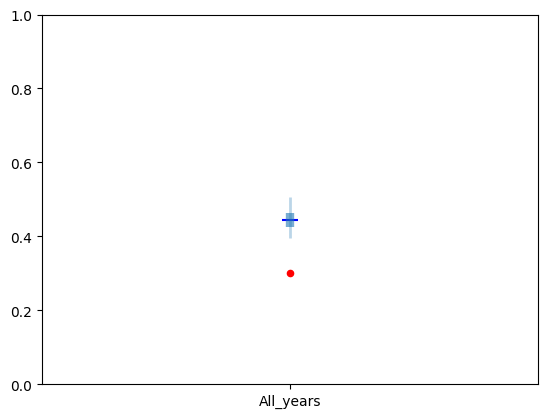

In [344]:
plt.vlines(x = "All_years", ymin=out1summary.loc[{'quantile':0.025}].data ,ymax = out1summary.loc[{'quantile':0.975}].data , linewidths = 2, alpha = 0.3)
plt.vlines(x = "All_years", ymin=out1summary.loc[{'quantile':0.25}].data ,ymax = out1summary.loc[{'quantile':0.75}].data , linewidths = 6, alpha = 0.6)
plt.scatter(x="All_years", y = out1summary.loc[{'quantile':0.5}].data,marker=0, c = 'blue')
plt.scatter(x="All_years", y = out1summary.loc[{'quantile':0.5}].data,marker=1, c = 'blue')
plt.scatter(x="All_years", y = outres1, c = 'red', s = 20)
plt.ylim((0,1))


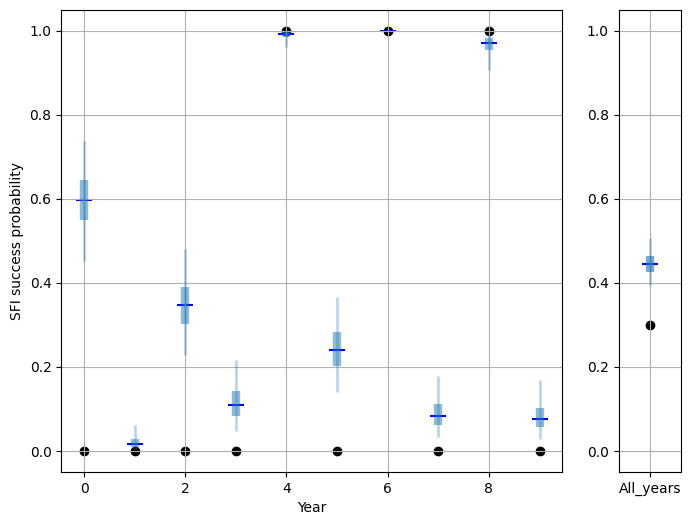

In [345]:
fig, ax = plt.subplots(1,2, figsize=(8,6), width_ratios=[8,1])

pltx = [a for a in range(predictdata1.shape[0])]
ax[0].scatter(x=pltx, y = predictdata1['BMF_R3'].values , c='black')
ax[0].vlines(x=pltx, ymin = outquants1.loc[{'quantile':0.025}].data ,ymax = outquants1.loc[{'quantile':0.975}].data , linewidths = 2, alpha = 0.3)
ax[0].vlines(x=pltx, ymin = outquants1.loc[{'quantile':0.25}].data ,ymax = outquants1.loc[{'quantile':0.75}].data , linewidths = 6, alpha = 0.5)
ax[0].scatter(x=pltx, y = outquants1.loc[{'quantile':0.5}].data,marker=0, c = 'blue')
ax[0].scatter(x=pltx, y = outquants1.loc[{'quantile':0.5}].data,marker=1, c = 'blue')
ax[0].grid()
ax[0].set_ylabel("SFI success probability")
ax[0].set_xlabel("Year")
ax[0].set_ylim((-0.05,1.05))

ax[1].scatter(x="All_years", y = outres1, c = 'black')
ax[1].vlines(x = "All_years", ymin=out1summary.loc[{'quantile':0.025}].data ,ymax = out1summary.loc[{'quantile':0.975}].data , linewidths = 2, alpha = 0.3)
ax[1].vlines(x = "All_years", ymin=out1summary.loc[{'quantile':0.25}].data ,ymax = out1summary.loc[{'quantile':0.75}].data , linewidths = 6, alpha = 0.6)
ax[1].scatter(x="All_years", y = out1summary.loc[{'quantile':0.5}].data,marker=0, c = 'blue')
ax[1].scatter(x="All_years", y = out1summary.loc[{'quantile':0.5}].data,marker=1, c = 'blue')

ax[1].set_ylim((-0.05,1.05))
ax[1].grid()

In [346]:
np.array(idata1.posterior_predictive.p.sum(dim = ("p_dim_2")).data/predictdata1.shape[0]).flatten()

array([0.41201893, 0.42742194, 0.41883038, ..., 0.47417798, 0.49531475,
       0.50160562])

(0.0, 1.0)

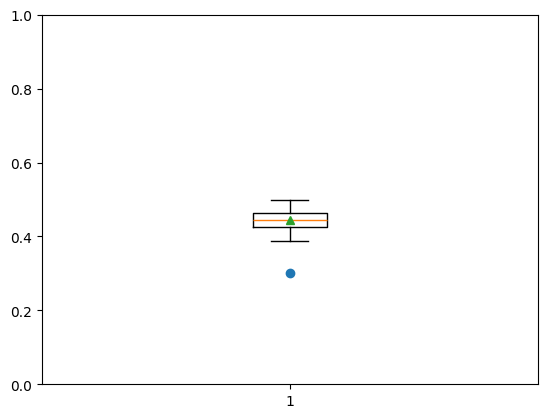

In [347]:
plt.boxplot( (idata1.posterior_predictive.p.sum(dim = ("p_dim_2") ).data/predictdata1.shape[0]).flatten() , whis = 0.95, showfliers= False, showmeans=True)
plt.scatter(x=1, y = outres1)
plt.ylim((0,1))

In [348]:
laggedinflow_predictor

,inflow_lagged,outflow_lagged,local_lagged,ewater_lagged
1895-06-30,8322251.0,3376607.0,5.651775e+06,2750.0
1896-06-30,6021355.0,2139088.0,4.251536e+06,2750.0
1897-06-30,8828884.0,1583839.0,5.022850e+06,2750.0
1898-06-30,8595550.0,2523049.0,6.169939e+06,2750.0
1899-06-30,8050405.0,2877384.0,5.119717e+06,2750.0
...,...,...,...,...
2004-06-30,7253731.0,1711289.0,5.462452e+06,2750.0
2005-06-30,8887863.0,2754732.0,6.492137e+06,2750.0
2006-06-30,2910648.0,723644.0,2.152755e+06,2750.0
2007-06-30,4761189.0,396686.0,2.827960e+06,2750.0


In [349]:
data = pd.concat([annualpredictor['inflow'], laggedinflow_predictor['inflow_lagged'],outdf['BMF_R3']],axis=1, join='inner')
data

,inflow,inflow_lagged,BMF_R3
1896-06-30,8322251.0,6021355.0,1.0
1897-06-30,6021355.0,8828884.0,0.0
1898-06-30,8828884.0,8595550.0,1.0
1899-06-30,8595550.0,8050405.0,0.0
1900-06-30,8050405.0,10863476.0,0.0
...,...,...,...
2004-06-30,9055549.0,7253731.0,0.0
2005-06-30,7253731.0,8887863.0,0.0
2006-06-30,8887863.0,2910648.0,0.0
2007-06-30,2910648.0,4761189.0,0.0


In [350]:
data.head()

,inflow,inflow_lagged,BMF_R3
1896-06-30,8322251.0,6021355.0,1.0
1897-06-30,6021355.0,8828884.0,0.0
1898-06-30,8828884.0,8595550.0,1.0
1899-06-30,8595550.0,8050405.0,0.0
1900-06-30,8050405.0,10863476.0,0.0


               inflow  inflow_lagged  BMF_R3
1896-06-30  8322251.0      6021355.0     1.0
1897-06-30  6021355.0      8828884.0     0.0
1898-06-30  8828884.0      8595550.0     1.0
1899-06-30  8595550.0      8050405.0     0.0
1900-06-30  8050405.0     10863476.0     0.0
...               ...            ...     ...
2004-06-30  9055549.0      7253731.0     0.0
2005-06-30  7253731.0      8887863.0     0.0
2006-06-30  8887863.0      2910648.0     0.0
2007-06-30  2910648.0      4761189.0     0.0
2008-06-30  4761189.0      3659820.0     0.0

[113 rows x 3 columns]
Add.0 p


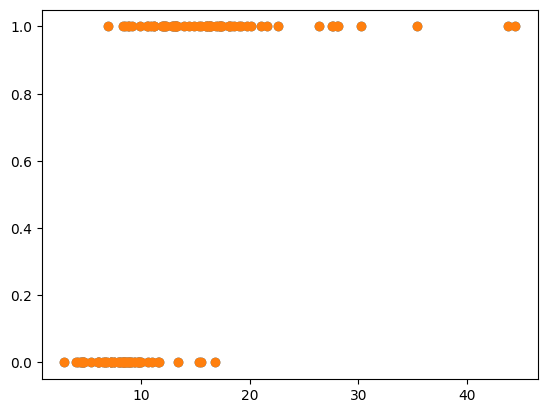

In [351]:

data = pd.concat([annualpredictor['inflow'], laggedinflow_predictor['inflow_lagged'],outdf['BMF_R3']],axis=1, join='inner')

#data = pd.concat([data ,outdf['BMF_R1']],axis=1, join='inner')
print(data)
data['inflow'] = (data['inflow']/1000000)
data['inflow_lagged'] = (data['inflow_lagged']/1000000)
data = data.reset_index()[data.columns[-3:]]

plt.scatter(x=data['inflow'], y= data['BMF_R3'])

data = data.sort_values(by = 'inflow')
n = 1 #data.shape

plt.scatter(data['inflow'], data['BMF_R3'], label = col)

with pymc.Model() as binomial_regression_model:
    x = pymc.Data("x", (data['inflow']))
    z = pymc.Data("z", (data['inflow_lagged']))
    # priors
    beta0 = pymc.Normal("beta0", mu=0, sigma=100)
    beta1 = pymc.Normal("beta1", mu=0, sigma=100)
    beta2 = pymc.Normal("beta2", mu=0, sigma=100)
    # linear model
    mu = beta0 + beta1 * x + beta2 * z
    p = pymc.Deterministic("p", pymc.math.invlogit(mu))
    print(mu, p)
    # likelihood
    pymc.Binomial("y", n=n, p=p, observed=data['BMF_R3'])

In [352]:
with binomial_regression_model:
    idata = pymc.sample(2000, tune=4000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 6 seconds.


array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>],
       [<Axes: title={'center': 'beta2'}>,
        <Axes: title={'center': 'beta2'}>]], dtype=object)

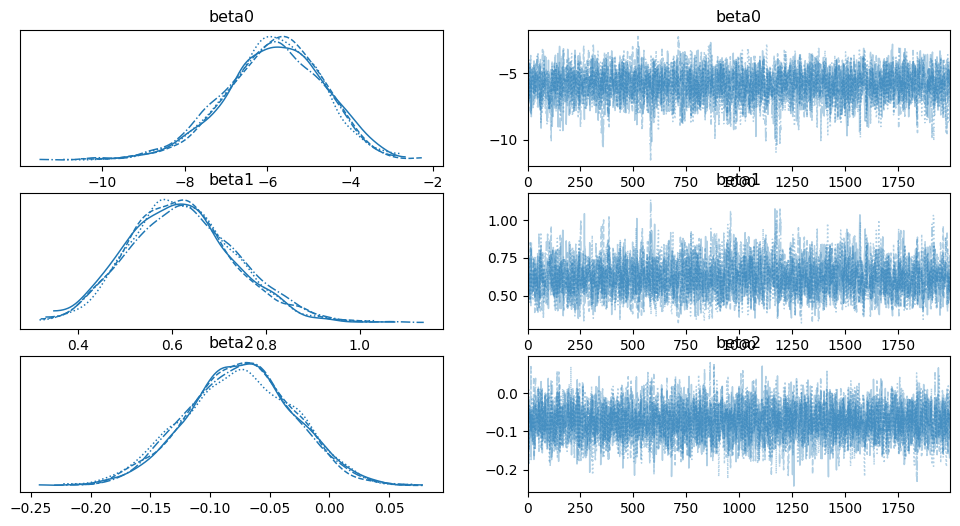

In [353]:
az.plot_trace(idata, var_names=["beta0", "beta1", "beta2"])

[[<matplotlib.axis.YTick at 0x176b6d8d0>,

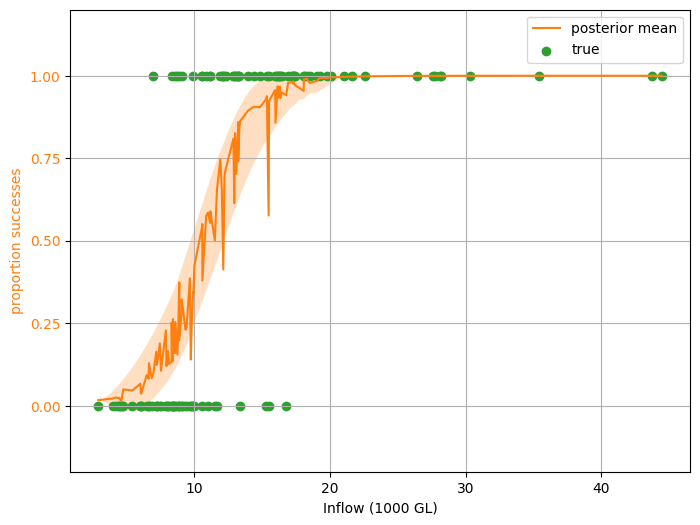

In [354]:
p_true = (data["BMF_R3"])
fig, ax = plt.subplots(1, 1, figsize=(8,6))

# Data space plot ========================================================
az.plot_hdi(
    data["inflow"],
    idata.posterior.p,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    ax=ax,
    color="C1",
)
# posterior mean
post_mean = idata.posterior.p.mean(("chain", "draw"))
ax.plot(data["inflow"], post_mean, label="posterior mean", color="C1")
# plot truth
ax.scatter(data["inflow"], p_true,  label="true", color="C2")
# formatting
ax.set(xlabel="Inflow (1000 GL)")
ax.set_ylabel("proportion successes", color="C1")
ax.tick_params(axis="y", labelcolor="C1")
ax.legend()
#ax.set_xscale('log')
# instantiate a second axes that shares the same x-axis
# freq = ax.twinx()
# freq.set_ylabel("number of successes")
# freq.scatter(data["inflow"], data["BMF_R3"], color="k", label="data")
# get y-axes to line up
y_buffer = 0.2
# freq.set(ylim=[-y_buffer, n + y_buffer])
ax.set(ylim=[-(y_buffer / n), 1 + (y_buffer / n)])
ax.grid()
# set both y-axis to have 5 ticks
ax.set(yticks=np.linspace(0, n, 5) / n)
#freq.set(yticks=np.linspace(0, n, 5))


In [355]:
outquants = idata.posterior.p.quantile(q= [0.05,0.25,0.5,0.75,0.95], dim = ("chain",'draw') )

In [356]:
data['inflow_lagged'].quantile([0.01]).values[0]

3.69765216

In [357]:
predictdata1 = data.copy(deep=True)
predictdata2 = data.copy(deep = True)
predictdata1['inflow_lagged'] = data['inflow_lagged'].quantile([0.01]).values[0]
predictdata2['inflow_lagged'] = data['inflow_lagged'].quantile([0.99]).values[0]
predictdata1['inflow'] = np.exp(np.log(data['inflow'].min() )+np.array([float(a)/float(data.shape[0]) for a in range(data.shape[0])] )* (np.log(data['inflow'].max())-np.log(data['inflow'].min())))

predictdata2['inflow'] = np.exp(np.log(data['inflow'].min() )+np.array([float(a)/float(data.shape[0]) for a in range(data.shape[0])] )* (np.log(data['inflow'].max())-np.log(data['inflow'].min())))

In [358]:
with binomial_regression_model:
    pymc.set_data({'x':predictdata1['inflow'], 'z':predictdata1['inflow_lagged']})
    idata1 = pymc.sample_posterior_predictive(idata,  var_names="p")

    pymc.set_data({'x':predictdata2['inflow'], 'z':predictdata2['inflow_lagged']})
    idata2 = pymc.sample_posterior_predictive(idata, var_names="p")

Sampling: []


Output()

Sampling: []


Output()

In [359]:
outquants1 = idata1.posterior_predictive.p.quantile(q= [0.05,0.25,0.5,0.75,0.95], dim = ("chain",'draw') )
outquants2 = idata2.posterior_predictive.p.quantile(q= [0.05,0.25,0.5,0.75,0.95], dim = ("chain",'draw') )

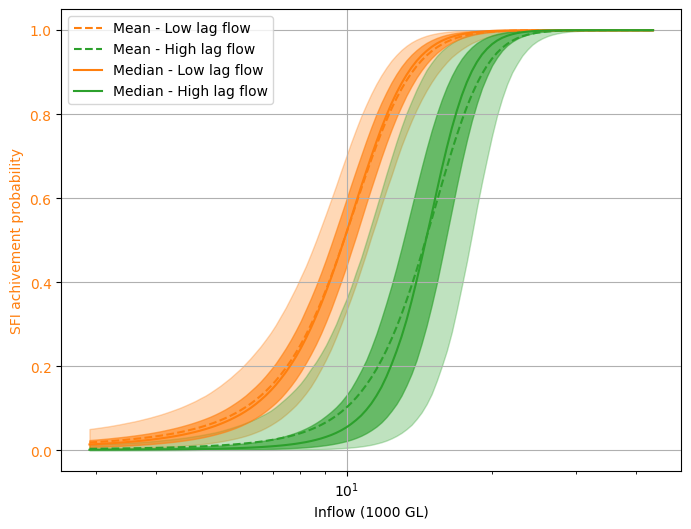

In [360]:
fig, ax = plt.subplots(1, 1, figsize=(8,6)) #, gridspec_kw={"width_ratios": [2, 1]})

ax.fill_between(x = (predictdata1['inflow']), y1 = outquants1.loc[{'quantile':0.05}].data ,y2 = outquants1.loc[{'quantile':0.95}].data, color = "C1", alpha = 0.3)
ax.fill_between(x = (predictdata2['inflow']), y1 = outquants2.loc[{'quantile':0.05}].data ,y2 = outquants2.loc[{'quantile':0.95}].data, color = "C2", alpha = 0.3)
ax.fill_between(x = (predictdata1['inflow']), y1 = outquants1.loc[{'quantile':0.25}].data ,y2 = outquants1.loc[{'quantile':0.75}].data, color = "C1", alpha = 0.6)
ax.fill_between(x = (predictdata2['inflow']), y1 = outquants2.loc[{'quantile':0.25}].data ,y2 = outquants2.loc[{'quantile':0.75}].data, color = "C2", alpha = 0.6)

# posterior mean
post_mean1 = idata1.posterior_predictive.p.mean(("chain", "draw"))
post_mean2 = idata2.posterior_predictive.p.mean(("chain", "draw"))
ax.plot(predictdata1["inflow"], post_mean1, label="Mean - Low lag flow", color="C1", linestyle = "--")
ax.plot(predictdata2["inflow"], post_mean2, label="Mean - High lag flow", color="C2", linestyle = "--")

ax.plot(predictdata1["inflow"], outquants1.loc[{'quantile':0.5}].data, label="Median - Low lag flow", color="C1")
ax.plot(predictdata2["inflow"], outquants2.loc[{'quantile':0.5}].data, label="Median - High lag flow", color="C2")

# plot truth
#ax.scatter(data["inflow"], p_true,  label="true", color="C2")
# formatting
ax.set(xlabel="Inflow (1000 GL)")
ax.grid()
ax.set_ylabel("SFI achivement probability", color="C1")
ax.tick_params(axis="y", labelcolor="C1")
ax.legend()
ax.set_xscale('log')


In [361]:
p_true = (data["BMF_R1"])
fig, ax = plt.subplots(1, 2, figsize=(15,5), gridspec_kw={"width_ratios": [2, 1]})

# Data space plot ========================================================
az.plot_hdi(
    predictdata2["inflow"],
    idata2.posterior_predictive.p,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    ax=ax[0],
    color="C1",
)
# posterior mean
post_mean = idata2.posterior_predictive.p.mean(("chain", "draw"))
ax[0].plot(predictdata2["inflow"], post_mean, label="posterior mean", color="C1")
# plot truth
ax[0].scatter(predictdata2["inflow"], p_true,  label="true", color="C2")
# formatting
ax[0].set(xlabel="Inflow (1000 GL)")
ax[0].set_ylabel("proportion successes", color="C1")
ax[0].tick_params(axis="y", labelcolor="C1")
ax[0].legend()


KeyError: 'BMF_R1'